### 딥러닝을 이용한 주가 추정
* NN: Neural Network: 신경망
* DNN: Deep NN: 심층 신경망
* CNN: Convolution NN: 합성곱 신경망
* RNN: Reucrrent NN: 순환 신경망
    - LSTM
* Optimizer
    - GD( 경사하강법
        - 단계적 하강
        
    - SGD(확률적 경사 하강법)Stochastic Gradient Descent
        - 학습률을 활용한 단계적 하강
        - 모멘텀 SGD: keras.optimizers.SGD(lr=0.1, momentum=0.9)
        - Nesterov Accelrated Gradient(NAG, 네스테로프 모멘텀)
            * 네스테로프 모멘텀은 momentum값과 gradient값이 더해저 실제(actual)값을 만드는 기존 모멘텀과 달리 momentum값이 적용된 지점에서 gradient값이 계산
            * keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)

    - Adagrad(Adaptive Gradient, 아다그라드)
        * 변수의 업데이트 횟수에 따라 학습률(Learning rate)를 조절하는 옵션이 추가된 최적화 방법
        * keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)
    - RMSprop(알엠에스프롭)
        * 아다그라드의 G(t)의 값이 무한히 커지는 것을 방지하고자 제안된 방법  지수 이동평균을 이용한 방법
        * optimize = tf.train.RMSPropOptimizer(learning_rate=0.01,decay=0.9,momentum=0.0,epsilon=1e-10).minimize(cost)
    - Adam(Adaptive Moment Estimation, 아담)
        * 기존 옵티마이저의 장단점을 고려한 옵티마이저
        * Adam은 Momentum과 RMSprop를 합친경사 
            - RMSprop의 특징인 gradient의 제곱을 지수평균한 값을 사용 
            - Momentum의 특징으로 gradient를 제곱하지 않은 값을 사용하여 지수평균을 구하고 수식
    - AdaDelta
        * Adagrad, RMSprop, Momentum 모두를 합친 경사하강법
        1. Adagrad 특징인 모든 step의 gradient 제곱의 합을 window size를 두어 window size만큼의 합으로 변경 이후 RMSprop과 똑같지 지수이동평균을 적용
        2.헤시안(Hessian) 근사법(Approximation)을 이용한 단위(Units) 수정
        * Adagrad, RMSprop, Momentum 모두를 합친 경사하강법
        * keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)


In [13]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
##>old d=[skey,'003490','대한항공',sday,sendp,sstartp,shighp,slowp,svol]
#d=[skey,'003490','대한항공',sday,sstartp,shighp,slowp,sendp,svol]
# 데이터 베이스 사용하기 SQLITE3
startday='1990-12-01'
def seldata(dstart=startday,dend='2021-12-20'):
    dbname='../_db/stockdb.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        cols='sday,sopenp,shighp,slowp,sclosep,svol'
        selsql="select "+cols+" from stockp where sday>='"+dstart+"' and sday<='"+dend+"' order by sday asc"
        sdata=cur.execute(selsql).fetchall()
    return sdata

In [42]:
sdata=seldata()
cols=['sday','sopenp','shighp','slowp','sclosep','svol']
sdf=pd.DataFrame(sdata,columns=cols)
tdf=sdf.set_index('sday')
tdf.head(10)

,sopenp,shighp,slowp,sclosep,svol
sday,,,,,
1996-06-25,18600,18800,18400,18500,51730
1996-06-26,18800,19000,18400,18600,124380
1996-06-27,18700,19100,18600,19000,79870
1996-06-28,19200,19400,18900,18900,68360
1996-06-29,18900,19000,18600,18900,38330
1996-07-01,18700,19400,18700,19300,33710
1996-07-02,19700,19800,19200,19200,77060
1996-07-03,19200,19200,18900,19000,42210
1996-07-04,19000,19100,18800,18900,34370


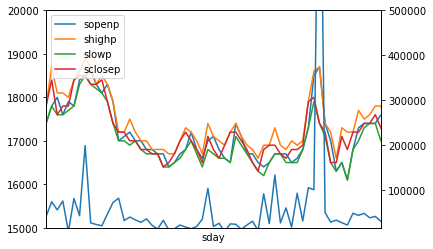

In [60]:
fig,ax1=plt.subplots()
tdf[['sopenp','shighp','slowp','sclosep']].plot( ax=ax1)
ax1.legend(loc=1)
plt.xticks(rotation=45)
plt.ylim(15000,20000,ax1)
ax2 = ax1.twinx()
tdf['svol'].plot(ax=ax2)
ax1.legend(loc=2)

plt.xticks(rotation=45)
plt.axhline(0,0,30,color='r',linestyle='--')
plt.ylim(15000,500000,ax2)
plt.xlim(30,90)
plt.show()

In [84]:
wsize=5
xdata=tdf[['sopenp','shighp','slowp','sclosep','svol']].values
X=[]
Y=[]
for i in range(len(xdata)-wsize):
    X.append(xdata[i:i+wsize].astype('float32'))
    Y.append(xdata[i+wsize][3])
print(X[3],Y[2])

[[19200. 19400. 18900. 18900. 68360.]
 [18900. 19000. 18600. 18900. 38330.]
 [18700. 19400. 18700. 19300. 33710.]
 [19700. 19800. 19200. 19200. 77060.]
 [19200. 19200. 18900. 19000. 42210.]] 19000


In [86]:
np.array(X).shape

(6397, 5, 5)

In [90]:
from sklearn.model_selection import train_test_split
cutratio=0.2
cut=-int(np.ceil(len(X)*cutratio))

X_train=np.array(X[:cut])
y_train=np.array(Y[:cut])
X_test=np.array(X[cut:])
y_test=np.array(Y[cut:])
print(X_train.shape,X_test.shape)


(5117, 5, 5) (1280, 5, 5)


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
model=Sequential()
model.add(LSTM(64,
               input_shape=(X_train.shape[1],X_train.shape[2]),
               activation='relu'
              )
         )
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['CosineSimilarity']
             )
hist=model.fit(X_train,y_train,epochs=100,batch_size=100)

Epoch 1/100
52/52 [==============================] - 0s 2ms/step - loss: 2038179.0000 - cosine_similarity: 1.0000
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 1135887.3750 - cosine_similarity: 1.0000
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 1200038.6250 - cosine_similarity: 1.0000
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 1345627.6250 - cosine_similarity: 1.0000
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 1303222.3750 - cosine_similarity: 1.0000
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 1157876.6250 - cosine_similarity: 1.0000
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 1163703.7500 - cosine_similarity: 1.0000
Epoch 8/100
52/52 [==============================] - 0s 2ms/step - loss: 1134530.6250 - cosine_similarity: 1.0000
Epoch 9/100
52/52 [==============================] - 0s 2ms/step - loss: 2461175.2500 - 

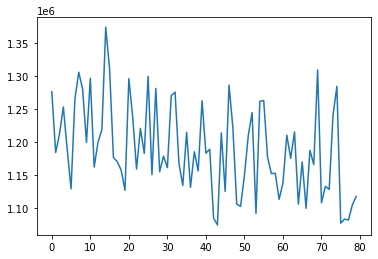

In [96]:
plt.plot(hist.history['loss'][20:])

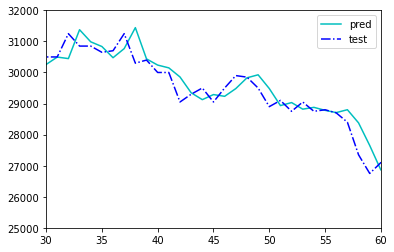

In [97]:

pred=model.predict(X_test)
plt.plot(pred,'c-',label='pred')
plt.plot(y_test,'b-.',label='test')
plt.xlim(30,60)
plt.ylim(25000,32000)
plt.legend()
plt.show()

In [98]:
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.metrics.pairwise import cosine_similarity

#acc=np.round(accuracy_score(pred,y_test),4)
def testeval(pred,y_test):
    mse=np.round(mean_squared_error(pred,y_test),4)
    r2=np.round(r2_score(pred,y_test),4)

    pred_m=pred.reshape(1,-1)
    y_test_m=y_test.reshape(1,-1)

    cos=np.round(cosine_similarity(pred_m,y_test_m),4)
    print('mse:',mse,'r2:',r2)
testeval(pred,y_test)

mse: 1018794.1483 r2: 0.9612


In [183]:
testeval(rfpred,y_test)

mse: 508338.3321 r2: 0.9808


### 전략
- 주식 보유 하고 있다
    * 오늘가격보다 내일 오른다: 대기
    * 오늘 가격보다 내일 하락:  매각
- 주식보유 하고 있다.
    * 오늘 가격보다 내일 오른다: 매수
    * 오늘 가격보다 내일 떨어진다: 대기

In [121]:
npred=pred.reshape(-1)
npred.shape

(1280,)

In [129]:
wdf=tdf.iloc[cut:,:].copy()
wdf['nclose']=npred
wdf.head(10)

,sopenp,shighp,slowp,sclosep,svol,nclose
sday,,,,,,
2016-10-10,32900,32900,32200,32250,208408,32262.593750
2016-10-11,32700,33250,32150,32400,439061,32462.587891
2016-10-12,32100,33100,32050,33050,289322,32700.449219
2016-10-13,33000,33250,32650,32650,269351,32723.945312
2016-10-14,32650,32950,32000,32000,305840,32901.378906
2016-10-17,32000,32300,31100,31850,330106,32230.572266
2016-10-18,31800,31850,30800,31100,505041,31648.410156
2016-10-19,31150,31550,30950,31250,306016,31281.142578
2016-10-20,31700,32250,31300,31300,458242,31203.230469


In [133]:
# 보유주식가격 오른다: 대기 
beforepos=-1 
beforehold=0 # 주식 보유여부
for i,row in wdf.iloc[:,:].iterrows():
    #print(i,'\n',row)
    if row['nclose']>row['sclosep']:
        nowpos=1 ## 매수 포지션
    else:
        nowpos=-1

    wdf.loc[i,'nowpos']=nowpos # 현재 포지션
    if nowpos > -1 and beforepos==-1 and beforehold==0: # 매수신호
        timing=1
        hold=1
        wdf.loc[i,'cash']=-row['sclosep']
    elif nowpos < 1 and beforepos==1 and beforehold==1:
        timing=-1
        hold=0
        wdf.loc[i,'cash']=row['sclosep']
    else:
        timing=0
        hold=beforehold
        wdf.loc[i,'cash']=0
        
    wdf.loc[i,'hold']=hold # 주식 보유 여부
    wdf.loc[i,'timing']=timing
    beforepos=nowpos
    beforehold=hold
wdf.loc[startday,'cash']=32000
wdf['cumcash']=wdf['cash'].cumsum()
wdf['balance']=wdf['sclosep']*wdf['hold']+wdf['cumcash']
scols=['sclosep','nowpos','timing','hold','cash','cumcash','balance']
print('시작가:',wdf['sclosep'][0],
      ' 종가:',wdf['sclosep'][-1],
      '차이:',wdf['sclosep'][-1]-wdf['sclosep'][0],
      '잔고:',wdf['balance'][-1],
      '수익:',wdf['balance'][-1]-wdf['balance'][0],
     )
wdf[scols].tail(30)


시작가: 32250.0  종가: nan 차이: nan 잔고: nan 수익: nan


,sclosep,nowpos,timing,hold,cash,cumcash,balance
sday,,,,,,,
2021-11-10,30450.0,1.0,0.0,1.0,0.0,-38600.0,-8150.0
2021-11-11,30550.0,-1.0,-1.0,0.0,30550.0,-8050.0,-8050.0
2021-11-12,30550.0,1.0,1.0,1.0,-30550.0,-38600.0,-8050.0
2021-11-15,30400.0,1.0,0.0,1.0,0.0,-38600.0,-8200.0
2021-11-16,30450.0,1.0,0.0,1.0,0.0,-38600.0,-8150.0
2021-11-17,29850.0,1.0,0.0,1.0,0.0,-38600.0,-8750.0
2021-11-18,29400.0,1.0,0.0,1.0,0.0,-38600.0,-9200.0
2021-11-19,29650.0,1.0,0.0,1.0,0.0,-38600.0,-8950.0
2021-11-22,29350.0,1.0,0.0,1.0,0.0,-38600.0,-9250.0
